In [1]:
"""Training script smpl deformation space experiment.
"""
import argparse
import json
import os
import glob
import numpy as np
from collections import defaultdict
import warnings
import time
import trimesh
from utils import render
import torch
import tqdm
from deepdeform.layers.deformation_layer import NeuralFlowDeformer
from deepdeform.layers.chamfer_layer import ChamferDistKDTree
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
import seaborn as sns
sns.set_style("white")

In [2]:
data_dir = "data/parametric_cad"
device = torch.device("cuda:0")
files = sorted(glob.glob(os.path.join(data_dir, "*.ply")))
meshes = [trimesh.load(f, process=False).apply_scale(0.001) for f in files]
verts_0 = np.array(meshes[0].sample(20000))
verts_1 = np.array(meshes[-1].sample(20000))
v_orig_0 = meshes[0].vertices
v_orig_1 = meshes[-1].vertices
faces = meshes[0].faces

## Setup

In [3]:
# options
deformer_nf = 16  # number of base feature layers in deformer
atol = 1e-2
rtol = 1e-2
nonlin = 'elu'
adjoint = False
solver = 'rk4'
niter = 200  # number of iterations
optimizer = torch.optim.Adam
learning_rate = 1e-3
criterion = torch.nn.L1Loss() # torch.nn.MSELoss()
log_per_n_iter = 20
divfree = False  # use divergence free parameterization
alpha_lap = 0
alpha_edge = 0
nsteps = 5
nsamp = 5000

In [4]:
# setup model
deformer = NeuralFlowDeformer(latent_size=1, f_width=deformer_nf, s_nlayers=2, 
                              s_width=5, method=solver, nonlinearity=nonlin, arch='imnet',
                              adjoint=adjoint, rtol=rtol, atol=atol, via_hub=False,
                              no_sign_net=False, return_waypoints=True, use_latent_waypoints=True,
                              divfree=divfree)

# for the linear case, we do not require the lat_params to be trainable.
lat_params = torch.linspace(-1, 1, nsteps)[:, None]
lat_params = lat_params.unsqueeze(0).to(device)
deformer.to(device)
optim = optimizer(deformer.parameters(), lr=learning_rate)
rev_seq = np.arange(lat_params.shape[1]-1, -1, -1)

chamfer_dist = ChamferDistKDTree(reduction='mean', njobs=1)
chamfer_dist.to(device)

ChamferDistKDTree()

In [5]:
# training loop:
v_src = torch.from_numpy(verts_0)[None].float().to(device)  # [1, nverts, 3]
v_tar = torch.from_numpy(verts_1)[None].float().to(device)  # [1, nverts, 3]
v_src_tar = torch.cat([v_src, v_tar], dim=0)
v_tar_src = torch.cat([v_tar, v_src], dim=0)
l_src_tar = torch.cat([lat_params, lat_params[:, rev_seq]], dim=0)

print("Optimizing ShapeFlow for 200 steps...")
for it in range(niter):
    rand_seq = np.random.choice(20000, nsamp)
    optim.zero_grad()
    v_prd = deformer(v_src_tar[:, rand_seq], l_src_tar)  # [2, nsamp, 3]
    _, _, dist = chamfer_dist(v_prd[-1], v_tar_src)
    loss = criterion(dist, torch.zeros_like(dist))
    loss.backward()
    optim.step()
    
    if it % log_per_n_iter == 0:
        print(f"Iter {it:4d}: loss {loss.item():.3e}")

Optimizing ShapeFlow for 200 steps...
Iter    0: loss 3.651e-02
Iter   20: loss 3.531e-02
Iter   40: loss 2.702e-02
Iter   60: loss 8.888e-03
Iter   80: loss 6.938e-03
Iter  100: loss 6.323e-03
Iter  120: loss 6.203e-03
Iter  140: loss 6.058e-03
Iter  160: loss 6.095e-03
Iter  180: loss 6.173e-03


Deformation sequence by ShapeFlow (ours)


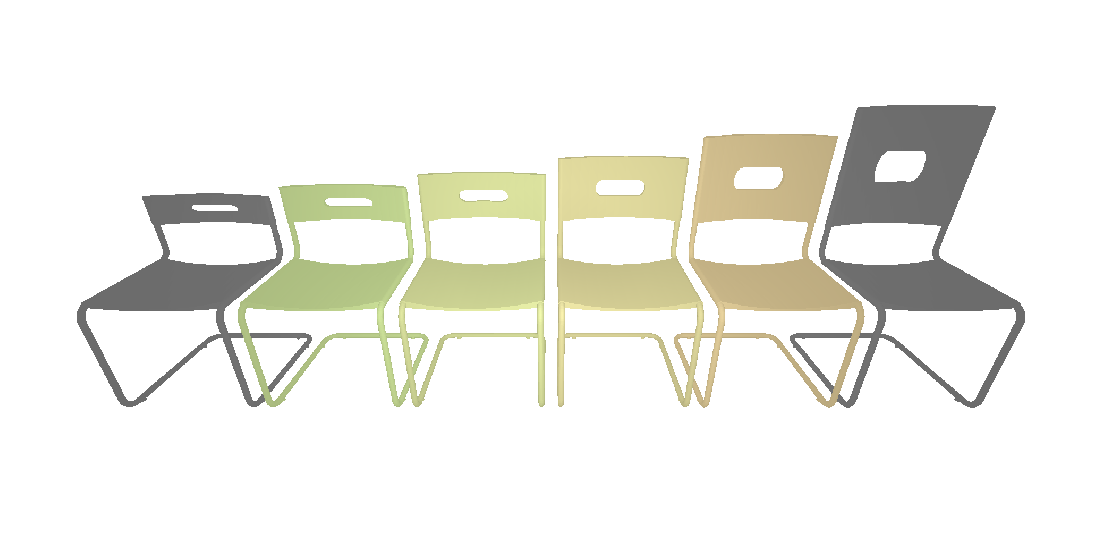

Deformation sequence by Parametric Ground Truth


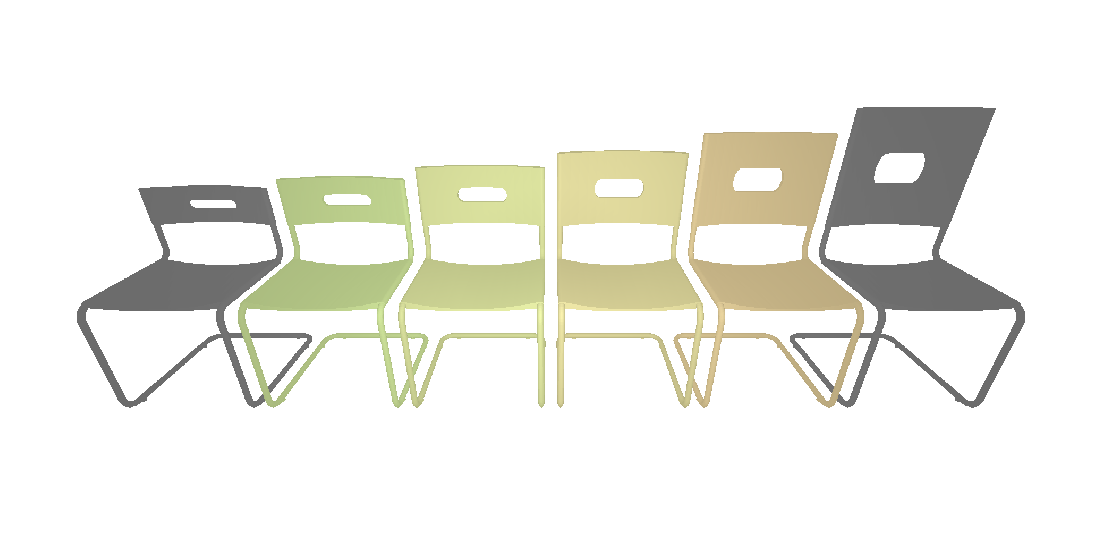

In [6]:
#### visualize
import matplotlib.pyplot as plt
%matplotlib inline

# evaluate
neval = 6

shift = np.array([0., 0., .6])
v_src_ = torch.from_numpy(v_orig_0)[None].float().to(device)  # [1, nverts, 3]
v_tar_ = torch.from_numpy(v_orig_1)[None].float().to(device)  # [1, nverts, 3]

lat_params_ = torch.linspace(-1, 1, neval)[None, :, None].to(device)
rev_seq_ = np.arange(lat_params_.shape[1]-1, -1, -1)
v_src_tar_ = torch.cat([v_src_, v_tar_], dim=0)
l_src_tar_ = torch.cat([lat_params_, lat_params_[:, rev_seq_]], dim=0)
with torch.no_grad():
    v_prd_seq_ = deformer(v_src_tar_, l_src_tar_)  # [nsteps, nverts, 3]
v_prd_mean = 0.5*(v_prd_seq_[:, 0] + v_prd_seq_[rev_seq_, 1])
v_prd_mean = v_prd_mean.detach().cpu().numpy()

meshes_deform = [trimesh.Trimesh(v_prd_mean[i], faces, process=False) for i in range(neval)]
meshes_gt = [meshes[i].copy() for i in np.arange(len(meshes))[::10]]

mesh_d_shift = [m.apply_translation(shift * i) for m, i in zip(meshes_deform, range(neval))]
mesh_g_shift = [m.apply_translation(shift * i) for m, i in zip(meshes_gt, range(neval))]

# visualize
alpha = np.linspace(0, 1, neval)
color0 = np.array([1., .7, .4, 1.0])
color1 = np.array([.7, 1., .4, 1.0])

for md, mg, a in zip(meshes_deform[1:-1], meshes_gt[1:-1], alpha[1:-1]):
    color = (1-a) * color0 + a * color1
    md.visual.vertex_colors = color
    mg.visual.vertex_colors = color
    
# Rendering view point
center = 0.5*(np.mean(meshes_deform[0].bounding_box.bounds, 0)+np.mean(meshes_deform[-1].bounding_box.bounds, 0))
zoom = 2.
eye = np.array([1., 0.5, 0.])
eye = eye / np.linalg.norm(eye) * zoom + center
up = np.array([0, 1, 0])
    
# render
img_d, _, _, _ = render.render_trimesh(mesh_d_shift, eye, center, up, res=(2048, 1024), light_intensity=8, ambient_intensity=.5)
img_g, _, _, _ = render.render_trimesh(mesh_g_shift, eye, center, up, res=(2048, 1024), light_intensity=8, ambient_intensity=.5)

def remove_bg(img):
    mask = np.linalg.norm(255-img, axis=-1) == 0
    alpha = np.ones_like(img[..., 0:1])
    alpha[mask] = 0
    return np.concatenate([img/255., alpha], axis=-1)

img_d = remove_bg(img_d)
img_g = remove_bg(img_g)

print("Deformation sequence by ShapeFlow (ours)")
plt.figure(figsize=(20, 10))
plt.imshow(img_d)
plt.axis('off')
plt.savefig("paper_figures/parametric_cad/deformed.png")
plt.show()

print("Deformation sequence by Parametric Ground Truth")
plt.figure(figsize=(20, 10))
plt.imshow(img_g)
plt.axis('off')
plt.savefig("paper_figures/parametric_cad/groundtruth.png")
plt.show()